In [36]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from syd import make_viewer

from src.files import results_dir
from src.plotting import errorPlot
from src.iaf.analysis import gather_metadata, gather_results, gather_rates, gather_weights, gather_num_connections, get_norm_factor
from src.iaf.plotting import build_ax_weight_fits

In [2]:
# Gotta add the config files to the run data (see new iaf_correlation.py script!!!)

In [26]:
experiment_folder = results_dir("iaf_runs") / "correlated" / "20250320"
metadata = gather_metadata(experiment_folder, experiment_type="correlation")
firing_rates = gather_rates(metadata, experiment_type="correlation")
num_connections = gather_num_connections(metadata, experiment_type="correlation")
weights = gather_weights(
    metadata,
    experiment_type="correlation",
    average_method="fraction",
    average_window=0.2,
    norm_by_max_weight=True,
    norm_by_num_synapses=True,
    num_connections=num_connections,
)

In [27]:
results = gather_results(metadata)

In [39]:
vars(results[0]["sim"]).keys()

dict_keys(['dt', 'neurons', 'source_populations'])

In [42]:
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

num_inputs = metadata["base_config"].sources["excitatory"].num_inputs
max_corr = metadata["base_config"].sources["excitatory"].max_correlation
xvals = np.linspace(max_corr, 0, num_inputs)

def plot(state):
    iratio = state["ratio"]
    isim = state["sim"]
    ineuron = state["neuron"]

    idx_to_sim = np.where(np.array(metadata["ratios"]) == iratio)[0][isim]
    c_result = results[idx_to_sim]
    c_rates = firing_rates[iratio, isim, ineuron]

    proximal = c_result["weights"][ineuron]["proximal"]
    distal_simple = c_result["weights"][ineuron]["distal-simple"]
    distal_complex = c_result["weights"][ineuron]["distal-complex"]

    norm_factors = get_norm_factor(c_result["sim"].neurons[ineuron], norm_by_max_weight=True, norm_by_num_synapses=True)

    fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
    ax[0].plot(range(metadata["duration"]), c_rates, color="k", linewidth=1.0)
    ax[1].imshow(proximal.T / norm_factors["proximal"], aspect="auto", cmap="gray_r", vmax=1, vmin=0)
    ax[2].imshow(distal_simple.T / norm_factors["distal-simple"], aspect="auto", cmap="gray_r", vmax=1, vmin=0)
    ax[3].imshow(distal_complex.T / norm_factors["distal-complex"], aspect="auto", cmap="gray_r", vmax=1, vmin=0)
    return fig

viewer = make_viewer(plot)
viewer.add_integer("ratio", min=0, max=num_ratios-1)
viewer.add_integer("sim", min=0, max=metadata["args"].repeats-1)
viewer.add_integer("neuron", min=0, max=metadata["args"].num_neurons-1)
viewer.show()

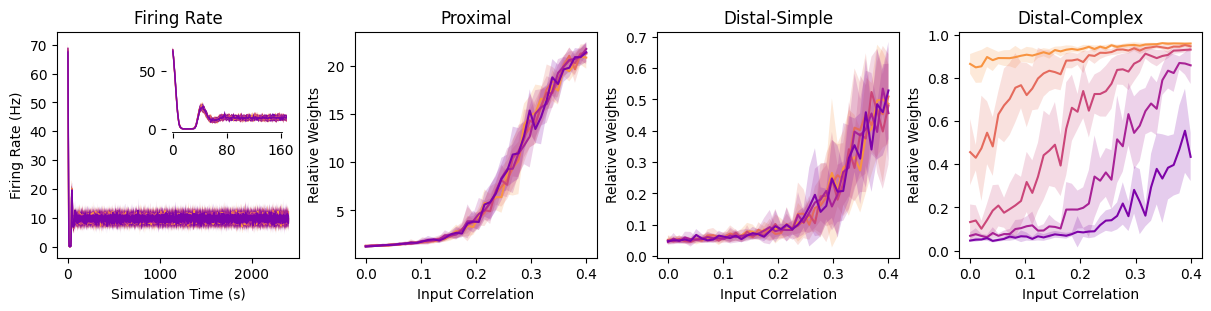

In [7]:
num_ratios = len(metadata["dp_ratios"])
cmap = mpl.colormaps["plasma_r"]
colors = [cmap(ii) for ii in np.linspace(0, 1, num_ratios+4)[2:-2]]

num_inputs = metadata["base_config"].sources["excitatory"].num_inputs
max_corr = metadata["base_config"].sources["excitatory"].max_correlation
xvals = np.linspace(max_corr, 0, num_inputs)

fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout="constrained")
inset = ax[0].inset_axes([0.45, 0.55, 0.5, 0.4])
for iratio in range(num_ratios):
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio], axis=1), axis=0, ax=ax[0], color=colors[iratio], linewidth=1.0)
    errorPlot(range(metadata["duration"]), np.mean(firing_rates[iratio], axis=1), axis=0, ax=inset, color=colors[iratio], linewidth=1.0)
    proximal_mean = np.mean(weights["proximal"][iratio], axis=1)  
    distal_simple_mean = np.mean(weights["distal-simple"][iratio], axis=1)
    distal_complex_mean = np.mean(weights["distal-complex"][iratio], axis=1)
    errorPlot(xvals, proximal_mean, axis=0, ax=ax[1], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(xvals, distal_simple_mean, axis=0, ax=ax[2], color=colors[iratio], alpha=0.2, linewidth=1.5)
    errorPlot(xvals, distal_complex_mean, axis=0, ax=ax[3], color=colors[iratio], alpha=0.2, linewidth=1.5)
ylim0 = ax[0].get_ylim()
inset.set_xlim(-10, 170)
inset.set_xticks([0, 80, 160])
inset.spines["top"].set_visible(False)
inset.spines["right"].set_visible(False)
inset.spines["left"].set_visible(False)
inset.spines["bottom"].set_visible(False)
inset.plot([0, 160], [ylim0[0], ylim0[0]], color="k", linewidth=2.0)
inset.set_ylim(ylim0)
ax[0].set_xlabel("Simulation Time (s)")
ax[0].set_ylabel("Firing Rate (Hz)")
ax[0].set_title("Firing Rate")
for axx, name in zip(ax[1:], ["Proximal", "Distal-Simple", "Distal-Complex"]):
    axx.set_xlabel("Input Correlation")
    axx.set_ylabel("Relative Weights")
    axx.set_title(name)
plt.show()

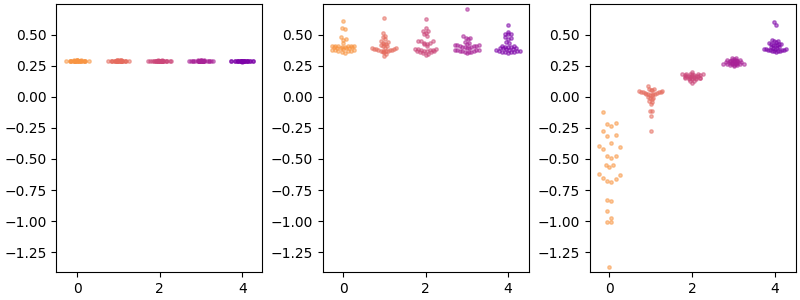

In [40]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3), layout="constrained")
_ = build_ax_weight_fits(ax[0], ax[1], ax[2], metadata, weights, share_ylim=True)
plt.show()

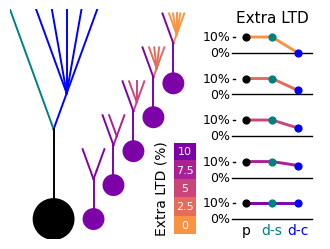

In [8]:
import numpy as np
from matplotlib import pyplot as plt
from src.plotting import FigParams, Proximal, DistalSimple, DistalComplex
from src.plotting import create_dpratio_colors
from src.schematics import Neuron, DPRatio, neuron_color_kwargs

num_neurons = 5
dpratio_colors = create_dpratio_colors(num_neurons)[0]
dpratios = np.linspace(0, 1, num_neurons) # relative to maxratio yvalue
group_colors = [Proximal.color, DistalSimple.color, DistalComplex.color]
labels = [Proximal.tinylabel, DistalSimple.tinylabel, DistalComplex.tinylabel]

# Build figure and axes
fig = plt.figure(figsize=(4, 4))#, **FigParams.all_fig_params())
ax_schematic = fig.add_subplot(1, 1, 1)

bounds = []

# Add schematic figure
neuron = Neuron(linewidth=FigParams.thicklinewidth)
elements = neuron.plot(ax_schematic, origin=(0, 0), scale=1.0, **neuron_color_kwargs(*group_colors))
bounds.append(neuron.get_bounds(elements))

xoffset = 1
yoffset = 0
xshift = 0.5
yshift = 0.85
for icolor, complex_color in enumerate(reversed(dpratio_colors)):
    origin = xoffset + icolor * xshift, yoffset + icolor * yshift
    c_colors = neuron_color_kwargs(dpratio_colors[-1], dpratio_colors[-1], complex_color)
    smaller_design = {"soma_size": 0.5, "trunk_height": 0.75, "tuft_height": 0.75, "complex_tuft_branches": 1 + icolor}
    elements = neuron.plot(ax_schematic, linewidth=FigParams.thicklinewidth, origin=origin, scale=1.0, **c_colors, **smaller_design)
    bounds.append(neuron.get_bounds(elements))

# Create the DPRatio object
max_ratio = 0.4
width = 2
pinch=0.175
yticks = [0, max_ratio]
markersize = 12
ytitle_yoffset = 0.29
yschema_shift = 2.6
pointcolors = [Proximal.color, DistalSimple.color, DistalComplex.color]
labelcolors = [Proximal.color, DistalSimple.color, DistalComplex.color]
dpratio = DPRatio(
    width=width,
    baselinewidth=FigParams.linewidth,
    linewidth=FigParams.thicklinewidth * 1.5,
    pinch=pinch,
    yticks=yticks,
    markersize=markersize * 2,
    ytitle_yoffset=ytitle_yoffset
)

xmax = np.max([b[1] for b in bounds])
for icolor, (complex_ratio, complex_color) in enumerate(zip(reversed(dpratios), reversed(dpratio_colors))):
    origin = xmax + width + width/10, icolor * max_ratio * yschema_shift
    cratios = np.array([1, 1, complex_ratio]) * max_ratio
    _, limits = dpratio.plot(
        ax_schematic,
        origin=origin,
        ratios=cratios,
        linecolor=complex_color,
        labels=labels if icolor==0 else None,
        title="Extra LTD" if icolor == num_neurons - 1 else None,
    )
    bounds.append(limits)

# Set axis limits
xmin = np.min([b[0] for b in bounds])
xmax = np.max([b[1] for b in bounds])
ymin = np.min([b[2] for b in bounds])
ymax = np.max([b[3] for b in bounds])
ax_schematic.set_xlim(xmin, xmax)
ax_schematic.set_ylim(ymin, ymax)
ax_schematic.set_aspect("equal")
ax_schematic.set_xticks([])
ax_schematic.set_yticks([])
for spine in ax_schematic.spines.values():
    spine.set_visible(False)

inset = ax_schematic.inset_axes([0.53, 0.02, 0.07, 0.4])
inset.imshow(np.stack(dpratio_colors)[::-1][:, None], aspect="auto", extent=[0, 1, -0.5, num_neurons-0.5])
for iratio, ratio in enumerate(dpratios):
    inset.text(0.5, iratio, f"{ratio*10:1g}", ha="center", va="center", fontsize=8, color="w")

inset.set_xticks([])
inset.set_yticks([])
inset.set_ylabel("Extra LTD (%)")
for spine in inset.spines.values():
    spine.set_visible(False)

plt.show()